In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns

import json
import re

#*----------------------------------------------------------------
mpl.rcParams['font.sans-serif'] = ['SimHei'] # *允许显示中文
plt.rcParams['axes.unicode_minus']=False# *允许显示坐标轴负数
#*----------------------------------------------------------------

params = {'legend.fontsize': 7,}

plt.rcParams.update(params)

# 数据的读入

In [2]:
file = open("data//OriginalData.json" , 'r' , encoding='utf-8')
original_data = json.load(file)
file.close()

In [3]:
print(original_data[0])
len(original_data)

{'片名': '肖申克的救赎 The Shawshank Redemption', '导演': '弗兰克·德拉邦特', '编剧': ['弗兰克·德拉邦特', '斯蒂芬·金'], '主演': ['蒂姆·罗宾斯', '摩根·弗里曼', '鲍勃·冈顿', '威廉姆·赛德勒', '克兰西·布朗', '吉尔·贝罗斯', '马克·罗斯顿', '詹姆斯·惠特摩', '杰弗里·德曼', '拉里·布兰登伯格', '尼尔·吉恩托利', '布赖恩·利比', '大卫·普罗瓦尔', '约瑟夫·劳格诺', '祖德·塞克利拉', '保罗·麦克兰尼', '芮妮·布莱恩', '阿方索·弗里曼', 'V·J·福斯特', '弗兰克·梅德拉诺', '马克·迈尔斯', '尼尔·萨默斯', '耐德·巴拉米', '布赖恩·戴拉特', '唐·麦克马纳斯'], '类型': ['剧情', '犯罪'], '制片国家/地区': ['美国'], '语言': ['英语'], '上映日期': ['1994-09-10(多伦多电影节)', '1994-10-14(美国)'], '片长': ['142分钟'], '评分': '9.7', '评价人数': '2568415'}


250

# 数据清洗

<font size = 4> 介于编剧和主演的多样性，并不能嵌入pandas进行数据分析，所以我们单把这两个数据拿出来，并根据剩下的数据进行归类</font>

<font size = 3>首先，我们发现，评分和评价人数对每个影片是唯一的，所以我们将这两项数据先单独拿出来构建dataframe</font>
<font size = 3>随后，对每个类型、国家、语言、上映时间还有片长做表格分类</font>

In [4]:
df_judge = pd.DataFrame(columns=['排名' , '片名' , '评分' , '评价人数'])
for index , film in enumerate(original_data):
    df_judge.loc[index] = [float(index + 1) , film['片名'] , float(film['评分']) , float(film['评价人数'])]

In [5]:
index = 0
df_types = pd.DataFrame(columns = ['排名' , '片名' , '类型' ])
for rank , film in enumerate(original_data):
    for i in film['类型']:
        df_types.loc[index] = [float(rank + 1) , film['片名'] , i]
        if(i == '普通话'): print(i)
        index += 1

In [6]:
index = 0
df_countries_areas = pd.DataFrame(columns = ['排名' , '片名' , '国家与地区' ])
for rank , film in enumerate(original_data):
    for area in film['制片国家/地区']:
        if '大陆' in area or '香港' in area or '台湾' in area:
            area = '中国'
        if '戛纳' in area:
            area = '法国'
        df_countries_areas.loc[index] = [float(rank + 1) , film['片名'] , area]
        index += 1

In [7]:
index = 0
df_languages = pd.DataFrame(columns = ['排名' , '片名' , '语言' ])
for rank , film in enumerate(original_data):
    for language in film['语言']:
        df_languages.loc[index] = [float(rank + 1) , film['片名'] , language]
        index += 1

In [8]:
index = 0
df_times = pd.DataFrame(columns = ['排名' , '片名' , '上映日期'])
for rank , film in enumerate(original_data):
    for time in film['上映日期']:
        df_times.loc[index] = [float(rank + 1) , film['片名'] , int(time[0:4])]
        index += 1

In [9]:
index = 0
df_lens = pd.DataFrame(columns = ['排名' , '片名' , '片长'])
for rank , film in enumerate(original_data):
    for lens in film['片长']:
        df_lens.loc[index] = [float(rank + 1) , film['片名'] , int(re.findall('\d+', lens)[0])]
        index += 1
        

# 描述性统计
首先粗浅看一下各个数据的关系

## 评分和评价人数

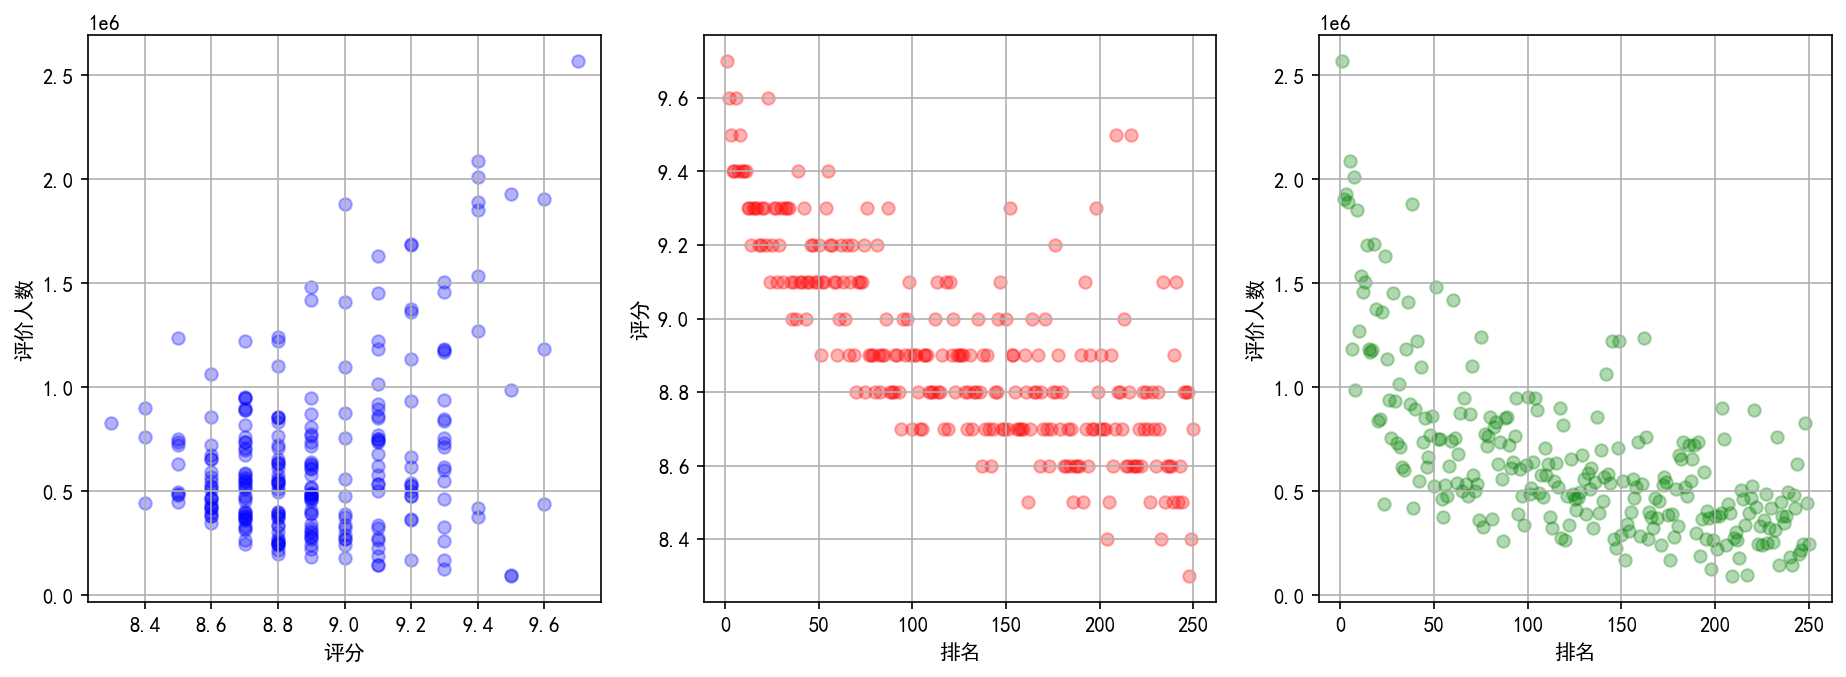

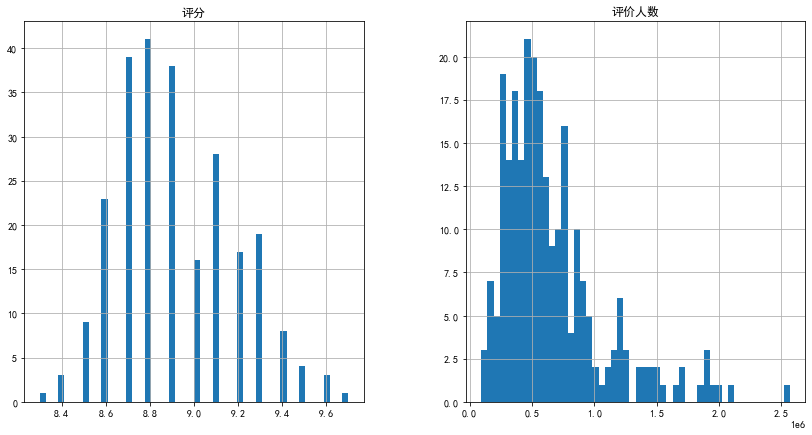

In [10]:
fig , axes = plt.subplots(1 , 3 , figsize = (15,5) , dpi = 150)
axes[0].scatter(df_judge.loc[: , '评分'] , df_judge.loc[: , '评价人数'] , color = 'blue' , alpha = 0.3)
axes[0].set_xlabel('评分') ; axes[0].set_ylabel('评价人数') ; axes[0].grid()

axes[1].scatter(df_judge['排名'] , df_judge['评分'] , color = 'red' , alpha = 0.3)
axes[1].set_xlabel('排名') ; axes[1].set_ylabel('评分') ; axes[1].grid()

axes[2].scatter(df_judge['排名'] , df_judge['评价人数'] , color = 'green' , alpha = 0.3)
axes[2].set_xlabel('排名') ; axes[2].set_ylabel('评价人数') ; axes[2].grid()
plt.show()
df_judge.loc[:,['评分','评价人数']].hist(bins =50 , figsize=(14,7))
plt.show()

<font size = 4>那么我们能够看到，评分和评价人数的关联从直观上来讲不太明显，反倒是排名和评分，排名和评价人数之间存在一定关联  
并且根据评分和评价人数的频数统计图我们可以看到，这两个特征都有明显的后尾分布的图像，那么在分析阶段会对这两个特征的分布进行检验</font>

## 影片的类型，国家，语言

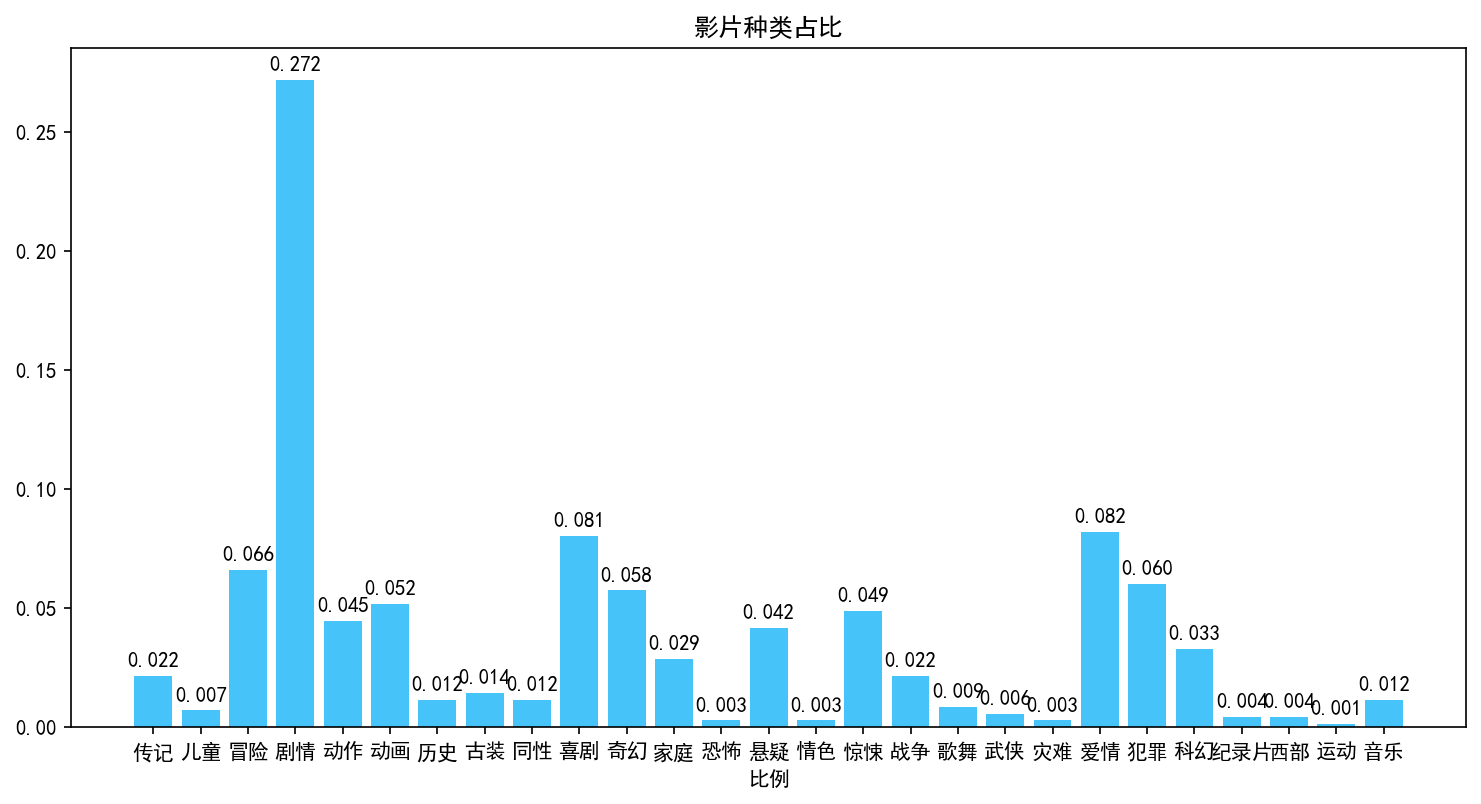

In [59]:
types = list(np.unique(df_types.loc[: , '类型']))
types_frequency = np.zeros(len(types))
for i in df_types.loc[: , '类型']:
    types_frequency[types.index(i)] += 1
types_frequency = types_frequency / np.sum(types_frequency)


fig  , axes = plt.subplots( figsize=(12,6) , dpi=150)
rect = axes.bar(types,types_frequency , color = '#46c3f9')
axes.set_title('影片种类占比') ; axes.set_xlabel('比例')

axes.bar_label(rect , padding = 3 , fmt = '%.3f')

plt.show()

<font size = 4>那么从上面所作图可以看到，剧情片的占比很高，其次是爱情片，喜剧片，那么自然而然的问题就是影片种类是否会对评分产生影响  
如果产生影响，那些类型的影片更容易获得高票数？影片种类是和否是直接影响因素，有没有间接变量？  </font>


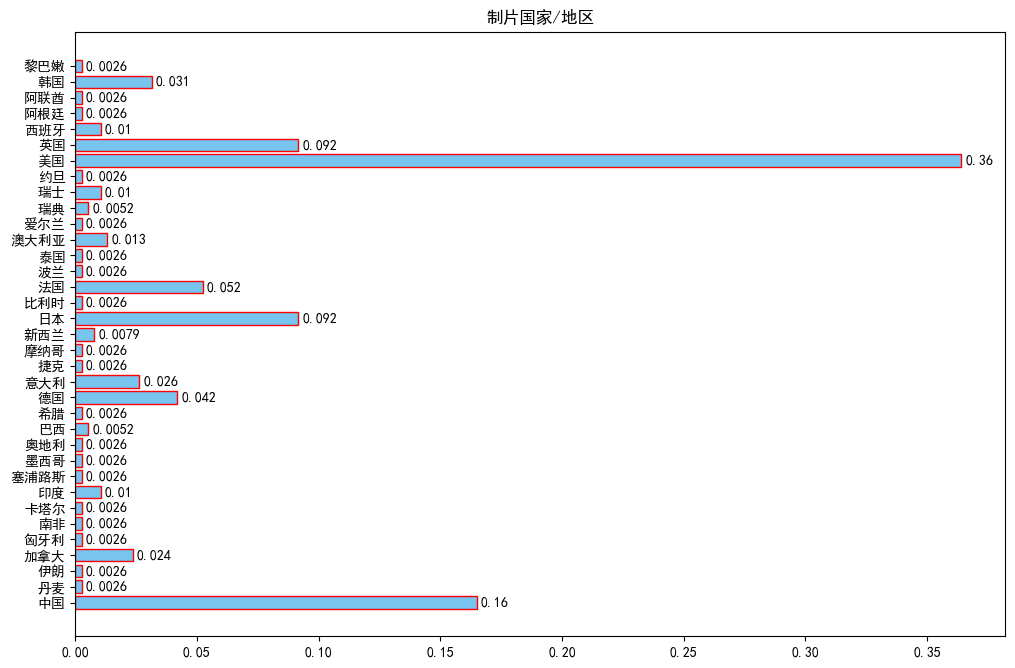

In [48]:
areas = list(np.unique(df_countries_areas.loc[: , '国家与地区']))
areas_frequency = np.zeros(len(areas))
for i in df_countries_areas.loc[: , '国家与地区']:
    areas_frequency[areas.index(i)] += 1

areas_frequency = areas_frequency/ np.sum(areas_frequency)

fig  , axes = plt.subplots( figsize=(12,8) , dpi = 100)
rect = axes.barh( areas , areas_frequency , color = '#77c4ee' , edgecolor = 'red')
axes.set_title('制片国家/地区占比') ; axes.set_xlabel('比例')
axes.bar_label(rect , padding = 3 , fmt='%.2g')
plt.show()

<font size = 4>还是一样的问题，制片国家是否会对评分产生影响？是积极影响还是消极影响？都需要进行统计性的检验</font>

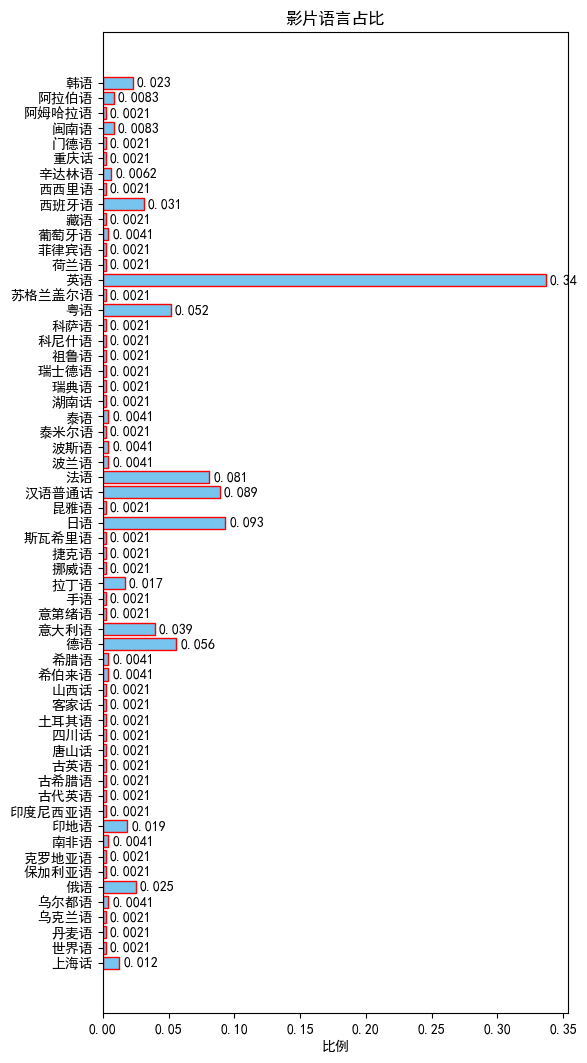

In [58]:
languages = list(np.unique(df_languages.loc[: , '语言']))
languages_frequency = np.zeros(len(languages))
for i in df_languages.loc[: , '语言']:
    languages_frequency[languages.index(i)] += 1

languages_frequency = languages_frequency/ np.sum(languages_frequency)

fig  , axes = plt.subplots( figsize=(6,13) , dpi = 100)
rect = axes.barh( languages , languages_frequency , color = '#77c4ee' , edgecolor = 'red')
axes.set_title('影片语言占比') ; axes.set_xlabel('比例')
axes.bar_label(rect , padding = 3 , fmt='%.2g')
plt.show()

# 数据挖掘

<font size = 4>首先我们来看看评分和评价人数之间有没有关系，如果有关系是什么</font>

In [14]:
df_judge.loc[: , ['排名' , '评分' , '评价人数']].corr(method = 'pearson')

,排名,评分,评价人数
排名,1.000000,-0.740512,-0.658202
评分,-0.740512,1.000000,0.335483
评价人数,-0.658202,0.335483,1.000000


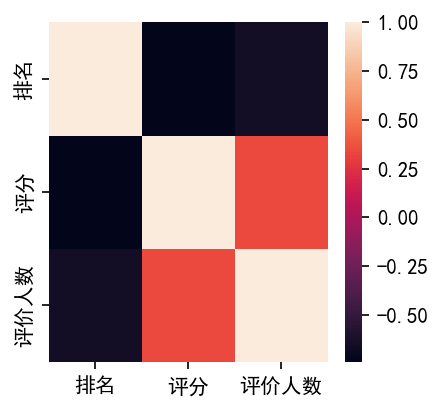

In [15]:
fig , axes = plt.subplots(figsize=(3,3) , dpi = 150)
sns.heatmap(df_judge.loc[: , ['排名','评分','评价人数']].corr() , ax = axes)
plt.show()

我们可以从相关系数矩阵看到，排名和评价人数以及评分相关性很大，评分和评价人数多少相关性不是很大，接下来做进一步分析，我们做一下回归

此时，我们大概率可以判断，评价人数和评分没有直接相关性，并不具备挖掘价值，但是排名和评分以及评价人数是存在相关性的，而且是比较明显的负相关，接下来进行进一步分析建模